## TODO
### Plumbing
- [DONE] add 'selected' column to dataframes, discard exp16 GAL pictures
- [DONE] remove cells straddling the border (implemented, needs a rerun)
- [DONE] make sure replicate colors are consistent (e.g. add pseudo-counts for absent replicate)
### Sanity checks
- [DONE] compare plots with original spots and decomposed spots
- [DONE] inspect cells with very high numbers of mRNAs
- [DONE] GAL exp16 09 has 140/143 cells with hipBA????
### Plots
- expression versus area/eccentricity
- expression versus growth rate
- plots: distance to centroid/wall/tip 
### Reprocess
- compute cell area on non-expanded masks

## Setup

### Imports

In [1507]:
from pathlib import Path
import pandas as pd
import re
import logging
import seaborn as sns
from itertools import combinations, product
from matplotlib import pyplot as plt
import numpy as np


#from IPython.utils import io

pd.options.display.precision = 2

In [994]:
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s ', datefmt='%m/%d/%Y %I:%M:%S%p', level=logging.INFO)
rootdir = "/Volumes/Flodrive/Florence/smFISH/analysis"

logging.info(f'reading from directory {rootdir}')

11/17/2024 05:03:23PM [INFO] reading from directory /Volumes/Flodrive/Florence/smFISH/analysis 


### Constants

In [1150]:
conditions = [
    {'label': 'LB', 'mu': 2.3},
    {'label': 'GLU', 'mu': 0.54},
    {'label': 'GLY', 'mu': 0.32},
    {'label': 'GAL', 'mu': 0.17},
    {'label': 'MAN', 'mu': 0.12},
]

growth_rates = {c['label']: c['mu'] for c in conditions}

mrna_ordered = ['rpoD', 'rnlAB', 'hipBA']
csources_ordered = [c['label'] for c in conditions]
replicates_ordered = ['exp16', 'exp22', 'exp24']

### Palettes

In [1151]:
palette_mrna = {
    'rpoD': 'magenta',
    'rnlAB': 'cyan',
    'hipBA': 'yellow',
}
palette_replicate = { z[0]: z[1] for z in zip(replicates_ordered, sns.color_palette("hls", len(replicates_ordered))) }
palette_csource = { z[0]: z[1] for z in zip(csources_ordered, sns.color_palette("viridis", len(csources_ordered))) }
palette_csource

{'LB': (0.267968, 0.223549, 0.512008),
 'GLU': (0.190631, 0.407061, 0.556089),
 'GLY': (0.127568, 0.566949, 0.550556),
 'GAL': (0.20803, 0.718701, 0.472873),
 'MAN': (0.565498, 0.84243, 0.262877)}

# Results

## Load data

#### Stacked format
- format with 1 row per cell and per mrna
- mrna is specified in 'mrna' column
- so this df has about 3x total number of cells rows (because we have 3 rna channels)

In [1075]:
dfs = []
for f in Path(rootdir).glob('*/*/results.csv'):
    cell_df = pd.read_csv(f.parent / "cells.csv")
    for mrna in mrna_ordered:
        f_mrna = Path(str(f) + f'.{mrna}')
        logging.info(f'..loading file: {f_mrna}')
        df = pd.read_csv(f_mrna)
        df['image'] = f_mrna.parts[-2]
        df['experiment'] = f_mrna.parts[-3]
        df = df.join(cell_df.set_index('image_cell_id'), on='image_cell_id')
        dfs.append(df)
df_stacked = pd.concat(dfs)

11/17/2024 07:04:37PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.rpoD 
11/17/2024 07:04:37PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.hipBA 
11/17/2024 07:04:37PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.rnlAB 
11/17/2024 07:04:38PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.rpoD 
11/17/2024 07:04:38PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.hipBA 
11/17/2024 07:04:38PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.rnlAB 
11/17/2024 07:04:38PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_05/results.csv.rpoD 
11

In [ ]:
df_stacked['mu'] = df_stacked.apply(lambda r: 'µ=' + growth_rates[r['csource']] + '(' + r['csource'] + ')', axis=1)


In [1354]:
pattern = re.compile(f'(?P<strain>[0-9A-Za-z]+)[_-](?P<csource>{"|".join(csources_ordered)})[-_](?P<coverslip>.*)')

def parse_image_name(r):
    s = r['image']
    match = pattern.search(s)
    d = match.groupdict()
    
    seqnr = re.search('(?P<seqnr>[0-9]+)$', d['coverslip'])[0]
    d['coverslip'] = re.sub('_[0-9]+$', '', d['coverslip'])
    return d['strain'], d['csource'], d['coverslip'], seqnr 

df_stacked[['strain', 'csource', 'coverslip', 'seqnr']] = df_stacked.apply(parse_image_name, axis=1, result_type='expand')
df_stacked['strain'] = 'MG1655'
df_stacked['replicate'] = df_stacked['experiment'].apply(lambda x: re.search('exp[0-9]+|LB$', x)[0])
df_stacked.loc[df_stacked['csource'] == 'LB', 'replicate'] = 'exp22'
df_stacked['unique_cell_id'] = df_stacked.apply(lambda r: r['replicate'] + "." + r['image'] + "." + str(r['image_cell_id']), axis=1)
df_stacked['selected'] = True
# after checking quality manually, we exclude 20241003-exp16 from the analysis:
df_stacked.loc[(df_stacked['experiment']=='20241003-exp16'), "selected"] = False
df_stacked.loc[:, 'mu'] = df_stacked.apply(lambda r: r['csource'] + '\n' + 'µ=' + str(growth_rates[r['csource']]) , axis=1)
df_stacked = df_stacked[df_stacked['selected']]
df_stacked


,image_cell_id,spots,dense_regions,decomposed_RNAs,tx,nascent_RNAs,total_RNAs,mrna,strain,condition,...,bbox-3,area,eccentricity,nuclei,csource,coverslip,replicate,unique_cell_id,selected,mu
0,531,0,0,0,0,0,0,rpoD,MG1655,GLU,...,522,600.0,0.83,1,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.531,True,GLU\nµ=0.54
1,533,0,0,0,0,0,0,rpoD,MG1655,GLU,...,925,710.0,0.83,1,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.533,True,GLU\nµ=0.54
2,535,0,0,0,0,0,0,rpoD,MG1655,GLU,...,842,803.0,0.94,2,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.535,True,GLU\nµ=0.54
3,537,0,0,0,0,0,0,rpoD,MG1655,GLU,...,228,672.0,0.89,2,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.537,True,GLU\nµ=0.54
4,540,0,0,0,0,0,0,rpoD,MG1655,GLU,...,826,621.0,0.93,1,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.540,True,GLU\nµ=0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,956,2,0,0,0,0,2,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,380,681.0,0.93,3,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.956,True,LB\nµ=2.3
483,965,1,0,0,0,0,1,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,336,554.0,0.92,2,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.965,True,LB\nµ=2.3
484,966,3,0,0,0,0,3,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,1244,1230.0,0.96,4,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.966,True,LB\nµ=2.3
485,974,1,1,2,1,2,2,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,589,800.0,0.91,2,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.974,True,LB\nµ=2.3


In [1110]:
48765 / 3

16255.0

In [1101]:
csources = df_stacked['csource'].unique()
strains = df_stacked['strain'].unique()
seqnrs = df_stacked['seqnr'].unique() 
mrnas = df_stacked['mrna'].unique() 
replicates = df_stacked['replicate'].unique()
experiments = df_stacked['experiment'].unique()
csources, strains, seqnrs, mrnas, replicates, experiments

(array(['GLU', 'GLY', 'GAL', 'MAN', 'LB'], dtype=object),
 array(['MG1655'], dtype=object),
 array(['01', '03', '05', '02', '06', '10', '04', '07', '08', '09', '11'],
       dtype=object),
 array(['rpoD', 'hipBA', 'rnlAB'], dtype=object),
 array(['exp24', 'exp22', 'exp16'], dtype=object),
 array(['20241029-exp24', '20241029-exp22', '20240927-exp16',
        '20240927-LB'], dtype=object))

In [1102]:
df_stacked.query('total_RNAs > 10')

,image_cell_id,spots,dense_regions,decomposed_RNAs,tx,nascent_RNAs,total_RNAs,mrna,strain,condition,...,bbox-3,area,eccentricity,nuclei,csource,coverslip,replicate,unique_cell_id,selected,mu
32,286,1,1,11,1,11,11,hipBA,MG1655,GLY,...,1627,524.0,0.85,1,GLY,left,exp24,exp24.exp24-GLY-left_02.286,True,0.32
85,358,10,4,18,0,0,24,hipBA,MG1655,GLY,...,131,1565.0,0.99,1,GLY,left,exp24,exp24.exp24-GLY-left_02.358,True,0.32
93,752,7,3,7,0,0,11,rpoD,MG1655,GLY,...,967,8749.0,0.95,8,GLY,left,exp24,exp24.exp24-GLY-left_03.752,True,0.32
93,752,18,3,11,0,0,26,hipBA,MG1655,GLY,...,967,8749.0,0.95,8,GLY,left,exp24,exp24.exp24-GLY-left_03.752,True,0.32
68,246,1,1,18,0,0,18,rnlAB,MG1655,GLY,...,1844,787.0,0.93,2,GLY,left,exp24,exp24.exp24-GLY-left_06.246,True,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,285,5,3,9,2,6,11,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,1254,1550.0,0.98,3,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.285,True,2.30
225,406,4,2,9,1,4,11,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,1115,934.0,0.94,3,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.406,True,2.30
379,719,7,3,10,2,7,14,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,614,1919.0,0.99,4,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.719,True,2.30
415,807,5,3,11,2,8,13,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,412,1263.0,0.99,4,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.807,True,2.30


In [1103]:
df_stacked.query('total_RNAs > 10')['mrna'].value_counts()

mrna
rpoD     146
rnlAB     43
hipBA     12
Name: count, dtype: int64

In [1104]:
df_stacked.query('dense_regions > 0')


,image_cell_id,spots,dense_regions,decomposed_RNAs,tx,nascent_RNAs,total_RNAs,mrna,strain,condition,...,bbox-3,area,eccentricity,nuclei,csource,coverslip,replicate,unique_cell_id,selected,mu
11,561,2,1,3,0,0,4,rpoD,MG1655,GLU,...,187,764.0,0.89,2,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.561,True,0.54
17,579,2,1,7,0,0,8,rpoD,MG1655,GLU,...,184,839.0,0.90,2,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.579,True,0.54
203,1069,1,1,2,1,2,2,rpoD,MG1655,GLU,...,1085,717.0,0.84,2,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.1069,True,0.54
234,1136,1,1,3,0,0,3,rpoD,MG1655,GLU,...,605,745.0,0.92,1,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.1136,True,0.54
245,1150,1,1,3,0,0,3,rpoD,MG1655,GLU,...,1135,468.0,0.88,1,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.1150,True,0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,939,2,1,7,1,7,8,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,1190,910.0,0.90,2,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.939,True,2.30
477,943,3,2,7,2,7,8,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,1601,1131.0,0.93,2,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.943,True,2.30
481,953,2,1,2,0,0,3,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,1893,1150.0,0.96,3,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.953,True,2.30
485,974,1,1,2,1,2,2,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,589,800.0,0.91,2,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.974,True,2.30


In [1105]:
(df_stacked.query('dense_regions > 0')['mrna'].value_counts())


mrna
rpoD     1233
rnlAB     706
hipBA     544
Name: count, dtype: int64

In [1106]:
df_stacked.query('tx > 0')['mrna'].value_counts()

mrna
rpoD     754
rnlAB    457
hipBA    264
Name: count, dtype: int64

#### Record format
- 1 row per cell, with info for all 3 mrna in this row
- number of rows = number of cells total (all processed pictures from all experiments)

In [1111]:
dfs = []
for f in Path(rootdir).glob('*/*/results.csv'):
    logging.info(f'..loading file: {f}')
    df = pd.read_csv(f)
    df['image'] = f.parts[-2]
    df['experiment'] = f.parts[-3]
    dfs.append(df)
df_records = pd.concat(dfs)

11/17/2024 08:42:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv 
11/17/2024 08:42:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv 
11/17/2024 08:42:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_05/results.csv 
11/17/2024 08:42:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_02/results.csv 
11/17/2024 08:42:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_03/results.csv 
11/17/2024 08:42:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_06/results.csv 
11/17/2024 08:42:13PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_10/results.csv 
11/17/2024 08:42:13PM [INFO] ..loading file: /Volumes

In [1114]:
df_records[['strain', 'csource', 'coverslip', 'seqnr']] = df_records.apply(parse_image_name, axis=1, result_type='expand')
df_records['strain'] = 'MG1655'
df_records['replicate'] = df_records['experiment'].apply(lambda x: re.search('exp[0-9]+|LB$', x)[0])
df_records.loc[df_records['csource'] == 'LB', 'replicate'] = 'exp22'
df_records['unique_cell_id'] = df_records.apply(lambda r: r['replicate'] + "." + r['image'] + "." + str(r['image_cell_id']), axis=1)
df_records['selected'] = True
# after checking quality manually, we exclude 20241003-exp16 from the analysis:
df_records.loc[(df_records['experiment']=='20241003-exp16'), "selected"] = False
df_records['mu'] = df_records.apply(lambda r: growth_rates[r['csource']], axis=1)
df_records = df_records[df_records['selected'] == True]
df_records


,image_cell_id,bbox-0,bbox-1,bbox-2,bbox-3,area,eccentricity,nuclei,spots_hipBA,dense_regions_hipBA,...,condition,seqnr,image,experiment,csource,coverslip,replicate,unique_cell_id,selected,mu
0,531,1,485,22,522,600.0,0.83,1,0,0,...,GLU,01,exp24-GLU-right-2_01,20241029-exp24,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.531,True,0.54
1,533,2,891,34,925,710.0,0.83,1,0,0,...,GLU,01,exp24-GLU-right-2_01,20241029-exp24,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.533,True,0.54
2,535,3,801,45,842,803.0,0.94,2,0,0,...,GLU,01,exp24-GLU-right-2_01,20241029-exp24,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.535,True,0.54
3,537,7,194,43,228,672.0,0.89,2,0,0,...,GLU,01,exp24-GLU-right-2_01,20241029-exp24,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.537,True,0.54
4,540,12,791,48,826,621.0,0.93,1,0,0,...,GLU,01,exp24-GLU-right-2_01,20241029-exp24,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.540,True,0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,956,951,335,969,380,681.0,0.93,3,0,0,...,LB_fixed2806_hybed1906_left,07,MG1655_LB_fixed2806_hybed1906_left_07,20240927-LB,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.956,True,2.30
483,965,956,295,975,336,554.0,0.92,2,1,0,...,LB_fixed2806_hybed1906_left,07,MG1655_LB_fixed2806_hybed1906_left_07,20240927-LB,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.965,True,2.30
484,966,956,1176,986,1244,1230.0,0.96,4,2,0,...,LB_fixed2806_hybed1906_left,07,MG1655_LB_fixed2806_hybed1906_left_07,20240927-LB,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.966,True,2.30
485,974,960,542,985,589,800.0,0.91,2,1,1,...,LB_fixed2806_hybed1906_left,07,MG1655_LB_fixed2806_hybed1906_left_07,20240927-LB,LB,fixed2806_hybed1906_left,exp22,exp22.MG1655_LB_fixed2806_hybed1906_left_07.974,True,2.30


In [1115]:
df_records.shape, df_stacked.shape

((16255, 37), (48765, 26))

In [1117]:
16255 * 3


48765

## Cell and spot counts

### Number of cells per csource

In [1119]:
df_records.groupby(['strain', 'csource', 'replicate'])['unique_cell_id'].agg('count')

strain  csource  replicate
MG1655  GAL      exp22        1955
        GLU      exp16        2825
                 exp22        1399
                 exp24        1060
        GLY      exp16         592
                 exp22        2405
                 exp24        1683
        LB       exp22         813
        MAN      exp16        1638
                 exp22        1885
Name: unique_cell_id, dtype: int64

##### Plot

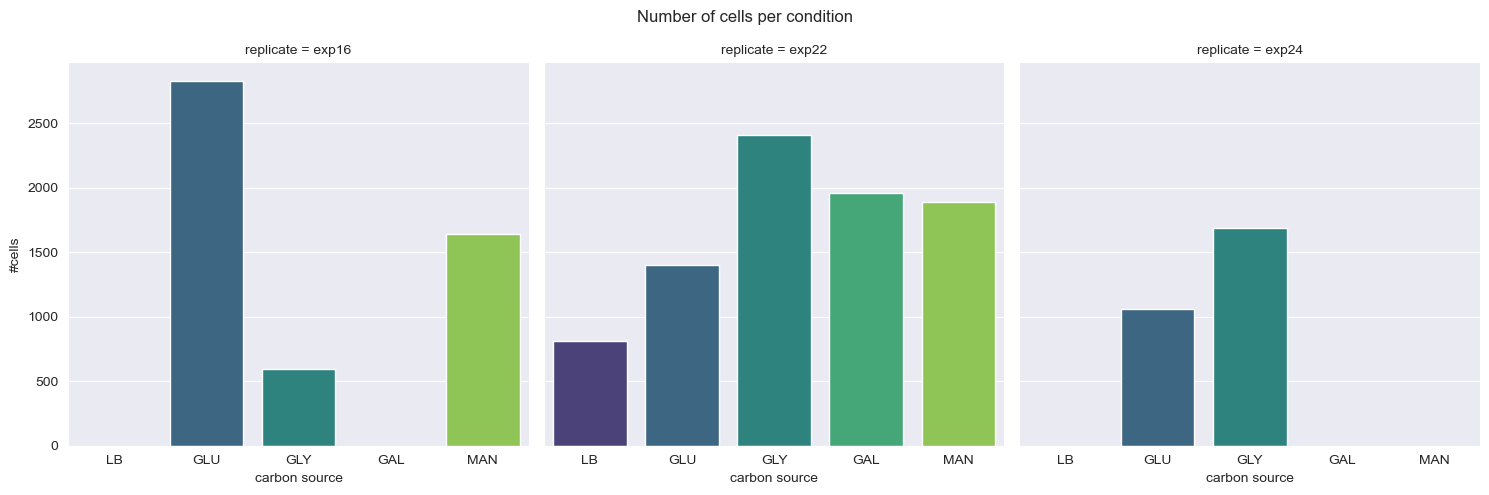

In [1460]:
g = sns.catplot(pd.DataFrame(df_records.groupby(['strain', 'csource', 'replicate'])['unique_cell_id'].agg('count')).reset_index(),
            col='replicate', col_order=replicates_ordered, 
            kind='bar', x='csource', order=csources_ordered, y='unique_cell_id', hue='csource', palette=palette_csource)
g.set(xlabel='carbon source', ylabel='#cells')
g.fig.suptitle('Number of cells per condition')
plt.tight_layout();

### Number of cells per csource per image

In [1121]:
df_records.groupby(['strain', 'csource', 'replicate', 'seqnr'])['unique_cell_id'].agg('count')

strain  csource  replicate  seqnr
MG1655  GAL      exp22      03       1030
                            04        407
                            07        312
                            08        206
        GLU      exp16      02        825
                            03        593
                            04        514
                            05        893
                 exp22      01        143
                            02         99
                            04        148
                            05        128
                            06        171
                            07         98
                            08        110
                            09        318
                            10        184
                 exp24      01        431
                            03        307
                            05        322
        GLY      exp16      01         16
                            03         19
                            04        231


### Number of spots per csource

In [1122]:
df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].agg(['sum'])


sum
strain csource replicate mrna       
MG1655 GAL     exp22     hipBA  1154
                         rnlAB   725
                         rpoD   1036
       GLU     exp16     hipBA  1033
                         rnlAB  2111
                         rpoD   6853
               exp22     hipBA   964
                         rnlAB   941
                         rpoD   4163
               exp24     hipBA   168
                         rnlAB   122
                         rpoD   1026
       GLY     exp16     hipBA    64
                         rnlAB   122
                         rpoD    390
               exp22     hipBA  1667
                         rnlAB  1292
                         rpoD   2538
               exp24     hipBA   511
                         rnlAB   308
                         rpoD   1153
       LB      exp22     hipBA  1153
                         rnlAB  2544
                         rpoD   4616
       MAN     exp16     hipBA   360
                         rnlAB   383
                         rpoD   1904
               exp22     hipBA   734
                         rnlAB   290
                         rpoD    628

#### Plot

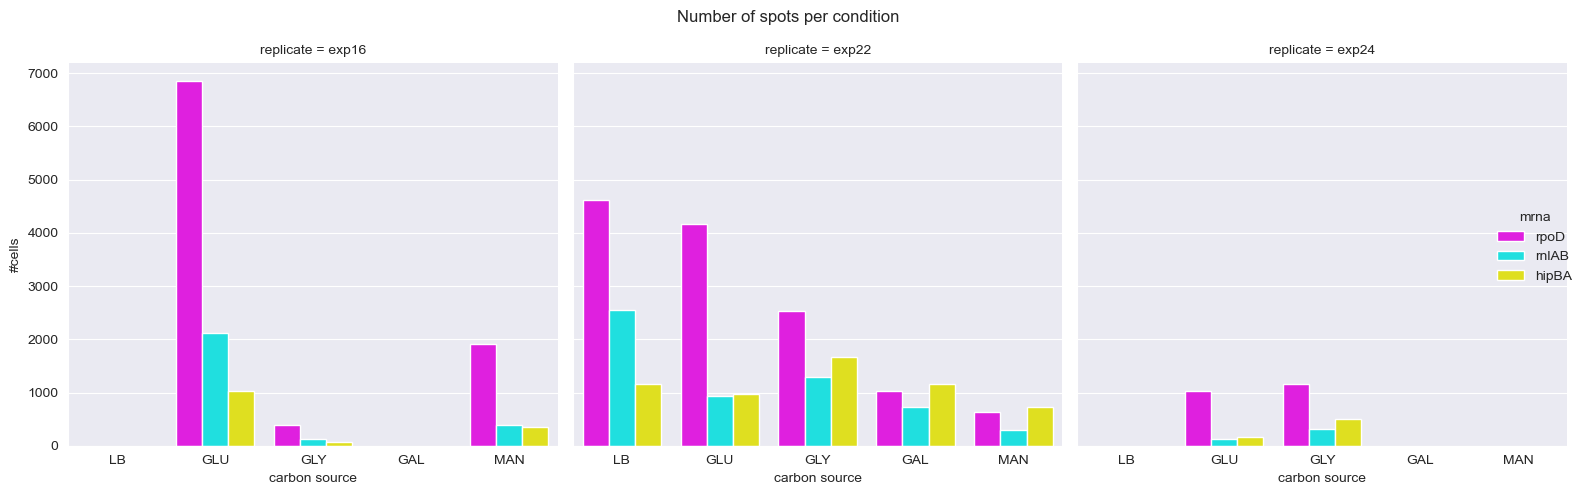

In [1567]:
g = sns.catplot(pd.DataFrame(df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].agg('sum')).reset_index(),
            col='replicate', col_order=replicates_ordered, 
            kind='bar', x='csource', order=csources_ordered, y='total_RNAs', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='#cells')
g.fig.suptitle('Number of spots per condition')
plt.tight_layout();

### Number of spots per csource per image per channel

In [1123]:
mrna_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna'])['total_RNAs'].sum()
mrna_counts

strain  csource  replicate  seqnr  mrna 
MG1655  GAL      exp22      03     hipBA    540
                                   rnlAB    316
                                   rpoD     469
                            04     hipBA    302
                                   rnlAB    179
                                           ... 
        MAN      exp22      05     rnlAB     29
                                   rpoD      89
                            06     hipBA    156
                                   rnlAB     54
                                   rpoD     118
Name: total_RNAs, Length: 132, dtype: int64

### Number of cells per csource per image exploded per channel

In [1124]:
cell_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna']).size()
cell_counts

strain  csource  replicate  seqnr  mrna 
MG1655  GAL      exp22      03     hipBA    1030
                                   rnlAB    1030
                                   rpoD     1030
                            04     hipBA     407
                                   rnlAB     407
                                            ... 
        MAN      exp22      05     rnlAB     254
                                   rpoD      254
                            06     hipBA     476
                                   rnlAB     476
                                   rpoD      476
Length: 132, dtype: int64

### Average number of spots per cell per image per channel
Normalize by cell counts to get frequencies

In [1571]:
frequencies_series = mrna_counts / cell_counts
frequencies_series.name = "frequencies"
frequencies = pd.DataFrame(frequencies_series).reset_index()
frequencies


,strain,csource,replicate,seqnr,mrna,frequencies
0,MG1655,GAL,exp22,03,hipBA,0.28
1,MG1655,GAL,exp22,04,hipBA,0.15
2,MG1655,GAL,exp22,07,hipBA,0.09
3,MG1655,GAL,exp22,08,hipBA,0.07
4,MG1655,GAL,exp22,03,rnlAB,0.16
...,...,...,...,...,...,...
127,MG1655,MAN,exp22,01,rpoD,0.05
128,MG1655,MAN,exp22,02,rpoD,0.06
129,MG1655,MAN,exp22,03,rpoD,0.12
130,MG1655,MAN,exp22,05,rpoD,0.05


#### Plot

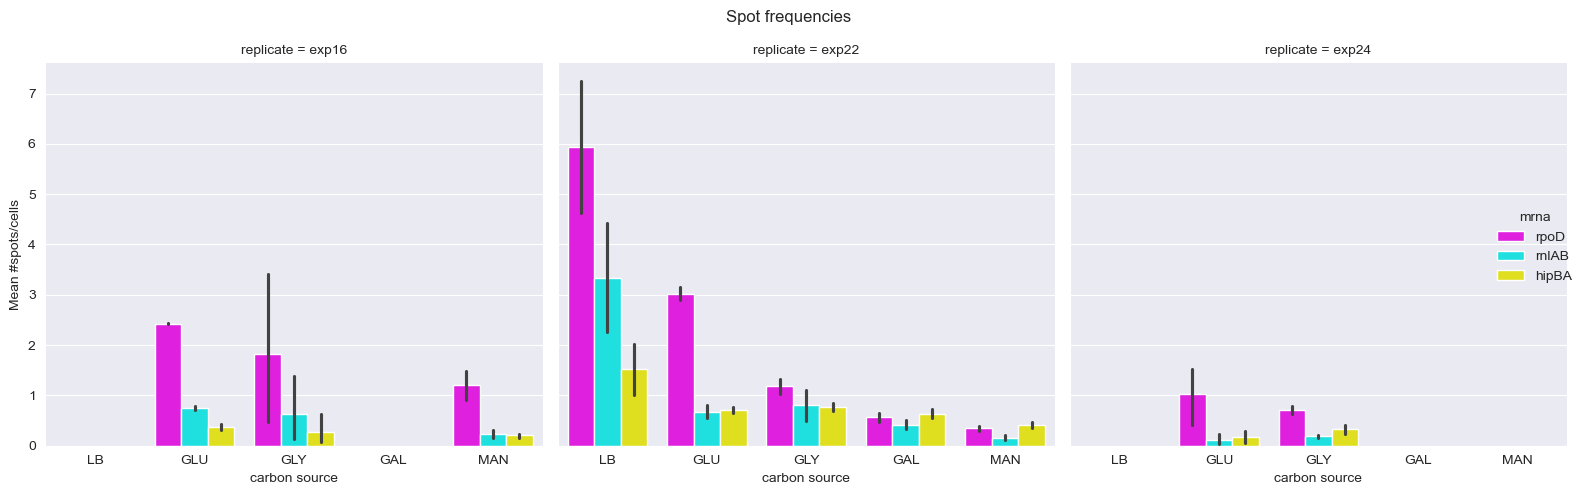

In [1570]:
g = sns.catplot(frequencies,
            col='replicate', col_order=replicates_ordered, 
            kind='bar', x='csource', order=csources_ordered, y='frequencies', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/cells')
g.fig.suptitle('Spot frequencies')
plt.tight_layout();

## Plots

### Cell feature distributions

#### Area per condition, all available data

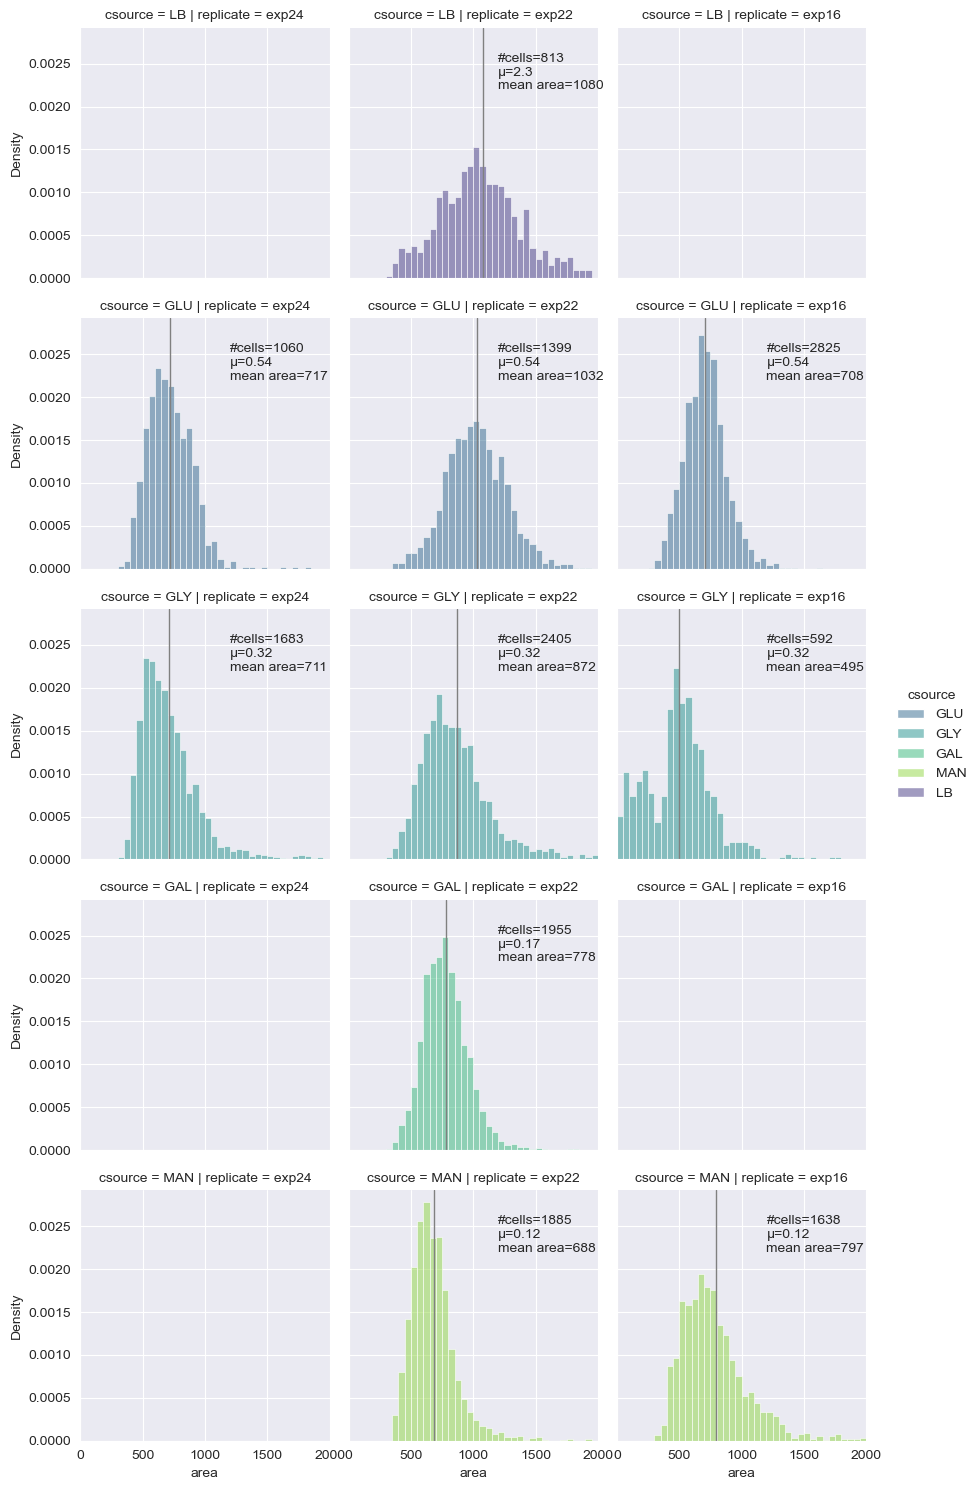

In [1472]:
g = sns.displot(
    data=df_records, x='area', stat='density', binrange=(0, 2000), bins=40, common_norm=False,
    row='csource', row_order=csources_ordered, col='replicate', col_order=replicates, 
    hue='csource', palette=palette_csource, 
    legend=True, height=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 2000))

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')
    
    data = df_records.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        mean = data['area'].mean()
        std = data['area'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(1200, 0.0022), xytext=(1200, 0.0022))

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
# 
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#     
#     print(row, col, hue_idx, data.shape)
#     
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

##### Inspect suspicious area values, fix segmentation manually

In [1471]:
df_records.query('replicate == "exp16"').query('csource == "MAN"').sort_values(by='area', ascending=False)[['experiment', 'image', 'image_cell_id', 'area', 'bbox-1', 'bbox-2']]

,experiment,image,image_cell_id,area,bbox-1,bbox-2
131,20240927-exp16,MG1655_MAN_OD_0.3_left_02,414,5219.0,1760,1077
210,20240927-exp16,MG1655_MAN_OD_0.3_left_02,642,3258.0,615,1588
360,20240927-exp16,MG1655_MAN_OD_0.3_left_09,1178,2835.0,477,1395
240,20240927-exp16,MG1655_MAN_OD_0.3_left_02,699,2753.0,2217,1677
307,20240927-exp16,MG1655_MAN_OD_0.3_left_02,905,2680.0,1973,2194
...,...,...,...,...,...,...
69,20240927-exp16,MG1655_MAN_OD_0.3_left_07,514,346.0,581,500
104,20240927-exp16,MG1655_MAN_OD_0.3_left_07,607,346.0,677,670
98,20240927-exp16,MG1655_MAN_OD_0.3_left_09,565,346.0,1687,367
35,20240927-exp16,MG1655_MAN_OD_0.3_left_09,427,344.0,797,133


#### Area and eccentricity versus condition

log(area) = f(mu)
In the following, we select exp22 because it is the most reliable, and the only complete, replicate.

In [1461]:
df_records.groupby(['strain', 'csource', 'replicate'])['area'].agg(['mean', 'median', 'std'])

mean  median     std
strain csource replicate                         
MG1655 GAL     exp22       777.60   763.0  185.02
       GLU     exp16       708.08   700.0  171.61
               exp22      1032.33  1018.0  294.44
               exp24       716.58   700.0  176.18
       GLY     exp16       494.63   495.0  269.53
               exp22       872.13   815.0  325.20
               exp24       710.54   659.0  303.04
       LB      exp22      1079.59  1037.0  402.83
       MAN     exp16       797.25   735.0  331.01
               exp22       688.41   652.0  253.09

##### Plot

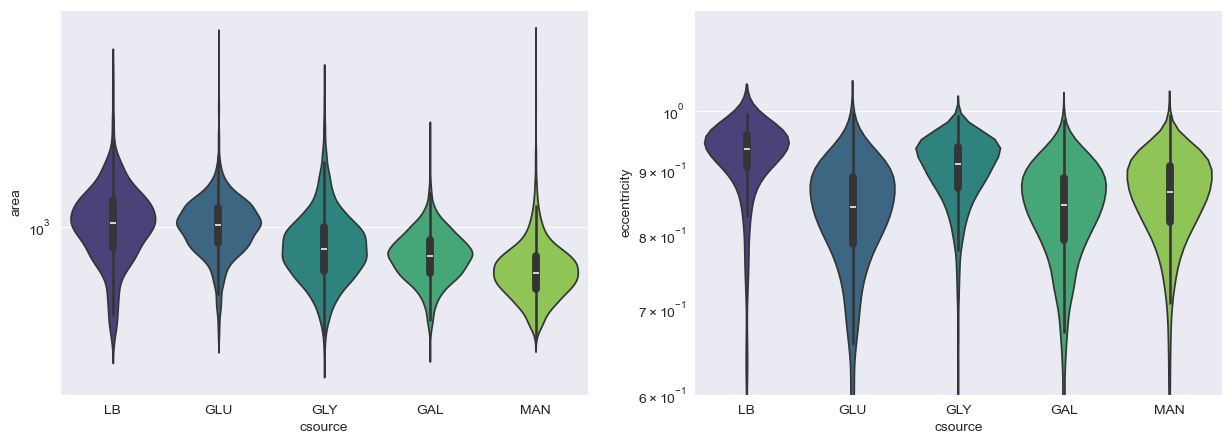

In [1573]:
data = df_records.query('replicate == "exp22"')
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.violinplot(data, x='csource', y='area', order=csources_ordered, log_scale=True, hue='csource', palette=palette_csource, ax=ax[0])
sns.violinplot(data, x='csource', y='eccentricity', order=csources_ordered, log_scale=True, hue='csource', palette=palette_csource, ax=ax[1]);
ax[1].set_ylim(0.6, 1.2);

#### Area per condition

##### Plot

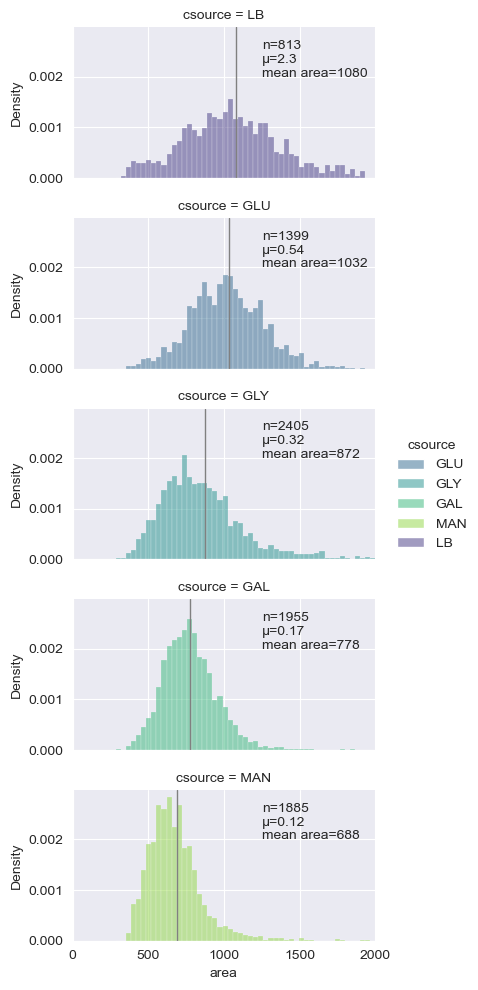

In [1440]:
data = df_records.query('replicate == "exp22"')
g = sns.displot(
    data=data, x='area', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, 
    hue='csource', palette=palette_csource, 
    legend=True, height=2, aspect=2,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 2000))

axes = g.axes.flatten()
for ax in axes:
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    mean = data.query('csource == @csource')['area'].mean()
    std = data.query('csource == @csource')['area'].std()
    mu = data.query('csource == @csource')['mu'].unique()[0]
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'n={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(1250, 0.002), xytext=(1250, 0.002))

#### Eccentricity per condition

##### Plot

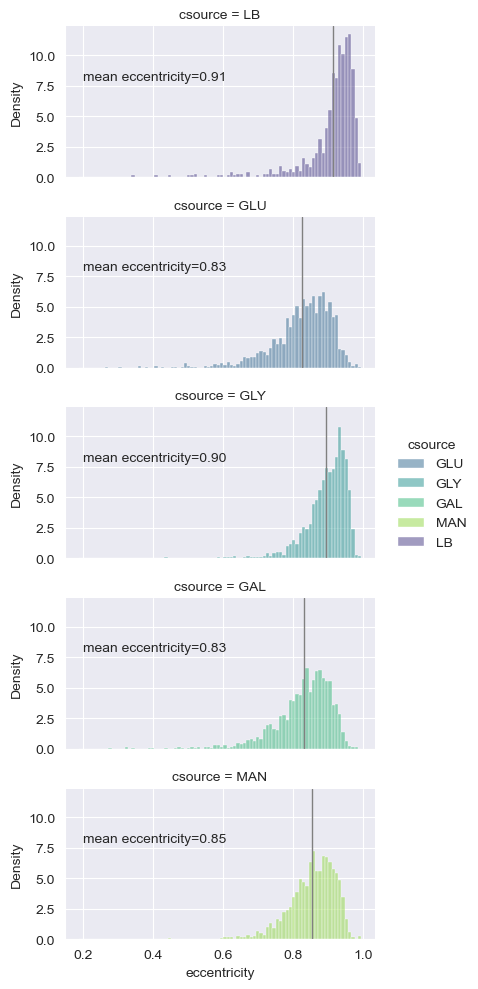

In [1213]:
data = df_records.query('replicate == "exp22"')
g = sns.displot(
    data=data, x='eccentricity', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, 
    hue='csource', palette=palette_csource, 
    legend=True, height=2, aspect=2,
    facet_kws=dict(sharey=True, sharex=True))

axes = g.axes.flatten()
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]

    mean = data.query('csource == @csource')['eccentricity'].mean()
    std = data.query('csource == @csource')['eccentricity'].std()

    if data.empty is False: 
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'mean eccentricity={mean:0.2f}', xy=(0.2, 8), xytext=(0.2, 8))

#### [TODO] Combine area and eccentricity distribution plots with representative picture for csource

### Expression versus growth rate

#### Mean number of spots per image
This is just to check how consistent the data is across images.

##### Plot - all data

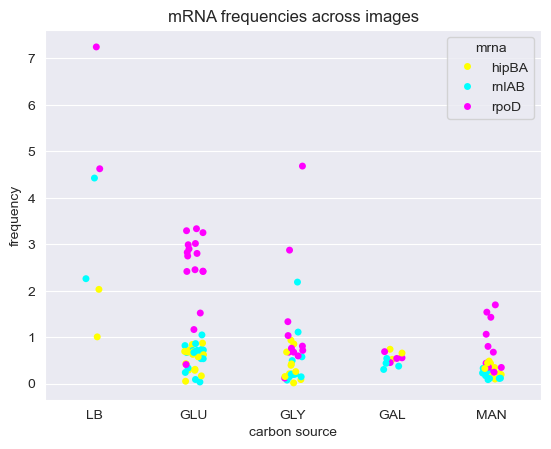

In [1356]:
g = sns.stripplot(frequencies, x='csource', order=csources_ordered, y='frequencies', hue='mrna', palette=palette_mrna)
g.set(title='mRNA frequencies across images', xlabel='carbon source', ylabel='frequency');
# numbers need to be consistent across images within one condition

##### Plot - only exp22 data

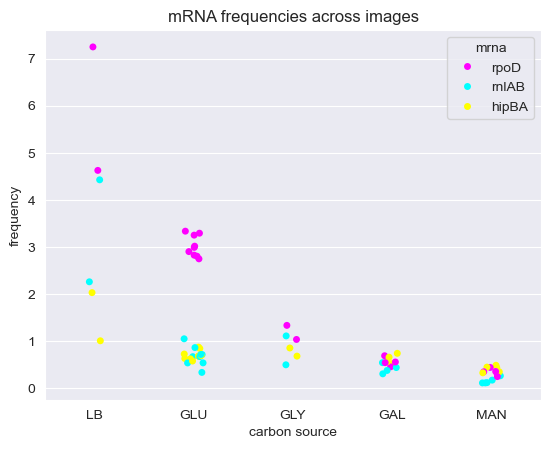

In [1474]:
g = sns.stripplot(frequencies.query('replicate == "exp22"'), 
                  x='csource', order=csources_ordered, y='frequencies', 
                  hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, 
                  dodge=False)
g.set(title='mRNA frequencies across images', xlabel='carbon source', ylabel='frequency');
# numbers need to be consistent across images within the same condition

##### Plot - excluding LB 

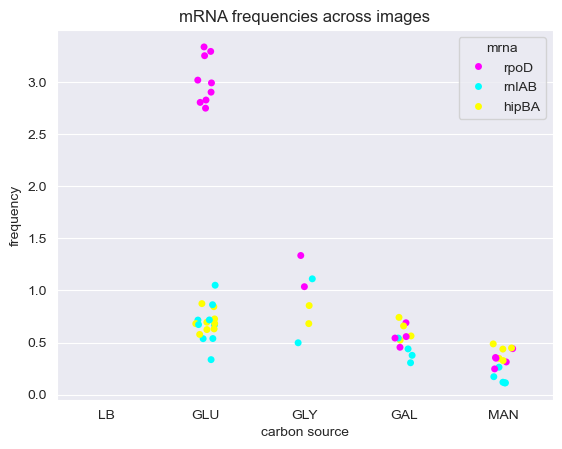

In [1475]:
g = sns.stripplot(frequencies.query('replicate == "exp22"').query('csource != "LB"'), 
                  x='csource', order=csources_ordered, y='frequencies', 
                  hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, 
                  dodge=False)
g.set(title='mRNA frequencies across images', xlabel='carbon source', ylabel='frequency');
# numbers need to be consistent across images within the same condition

#### Mean expression per condition

##### Plot

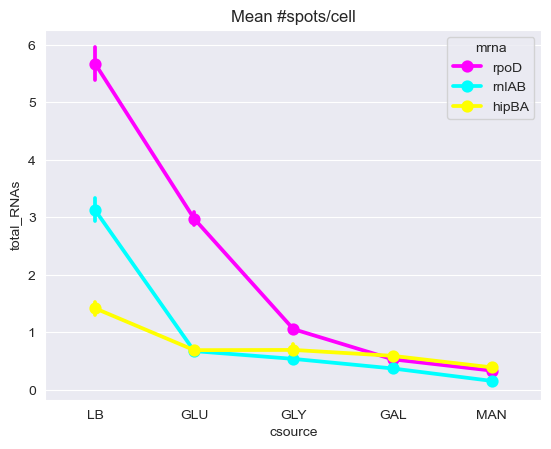

In [1579]:
data=df_stacked.query('replicate == "exp22"')
g = sns.pointplot(data=data, x='csource', order=csources_ordered, y='total_RNAs', 
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(title='Mean #spots/cell');
# g.set(yscale="log");




#### Distribution facetted by csource and mRNA

Cell expression histograms per csource per mRNA = 
#spots/cell for csource, aggregated over all images for csource
[TODO] add the mean


##### Plot - all data

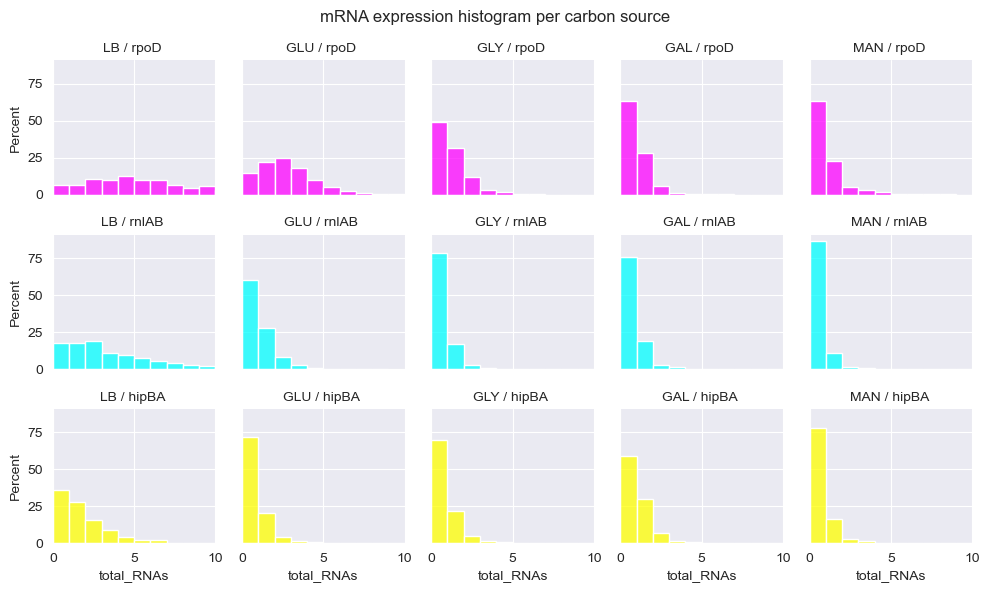

In [1227]:
g = sns.FacetGrid(df_stacked, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='total_RNAs', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();

##### Plot - only exp22 data

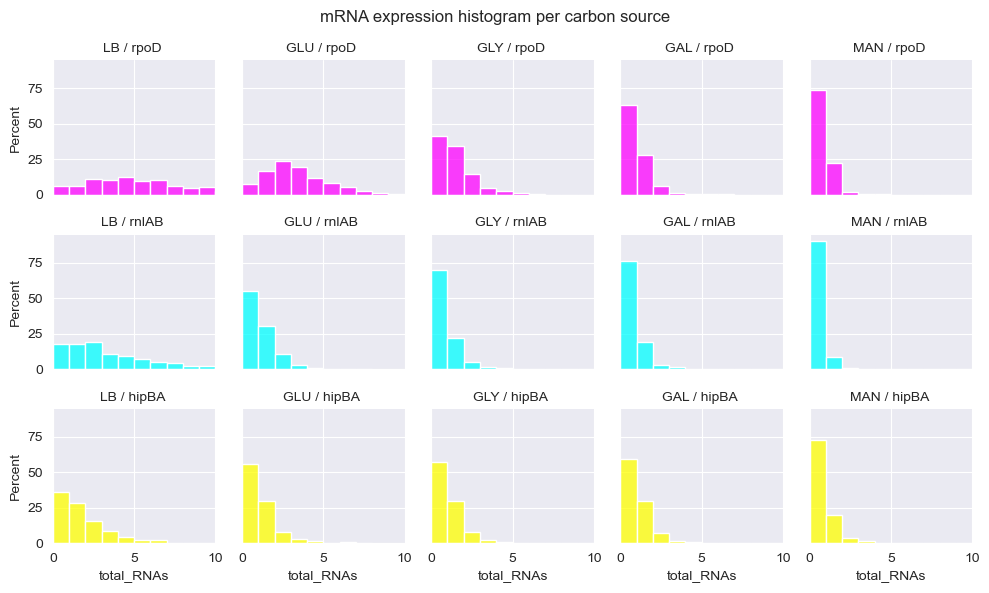

In [1226]:
data = df_stacked.query('replicate == "exp22"')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='total_RNAs', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();

#### Distribution of number of spots

##### Plot - which I don't fully understand

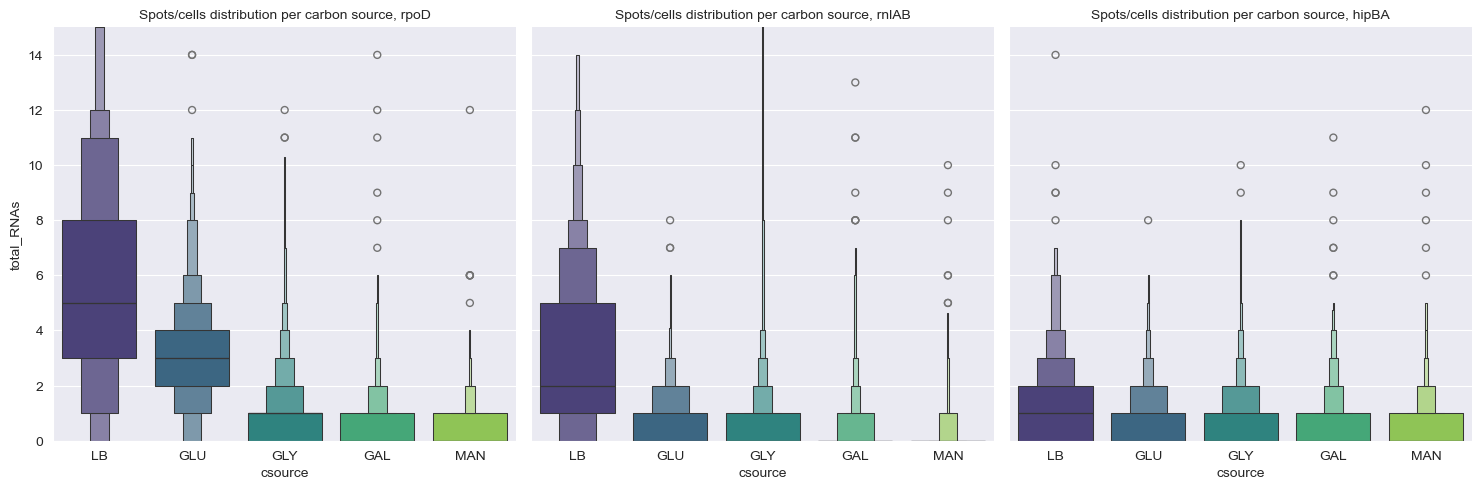

In [1535]:
data =df_stacked.query('replicate == "exp22"')
g = sns.catplot(data=data, kind='boxen', x='csource', order=csources_ordered, y='total_RNAs', width_method='exponential', 
            col='mrna', col_order=mrna_ordered,
            hue='csource', palette=palette_csource)
g.set_titles('Spots/cells distribution per carbon source, {col_name}')
g.set(ylim=(0, 15));

#### Evolution of fraction of cells with n spots with growth rate

In [1536]:
dfs = []
for (mrna, csource) in product(mrna_ordered, csources_ordered):
    d = data.query('mrna == @mrna').query('csource == @csource')
    counts = np.bincount(d['total_RNAs'])
    df = pd.DataFrame({
        'mrna': mrna,
        'csource': csource,
        'rank': np.arange(len(counts)),
        'nr_cells_at_rank': np.bincount(d['total_RNAs']),
        'nr_cells_total': np.full_like(counts, d.shape[0]), 
    })
    # print(df)
    dfs.append(df)
histograms = pd.DataFrame(pd.concat(dfs))
histograms['frequency'] = histograms['nr_cells_at_rank'] / histograms['nr_cells_total']
histograms

,mrna,csource,rank,nr_cells_at_rank,nr_cells_total,frequency
0,rpoD,LB,0,53,813,6.52e-02
1,rpoD,LB,1,52,813,6.40e-02
2,rpoD,LB,2,89,813,1.09e-01
3,rpoD,LB,3,83,813,1.02e-01
4,rpoD,LB,4,102,813,1.25e-01
...,...,...,...,...,...,...
8,hipBA,MAN,8,1,1885,5.31e-04
9,hipBA,MAN,9,1,1885,5.31e-04
10,hipBA,MAN,10,1,1885,5.31e-04
11,hipBA,MAN,11,0,1885,0.00e+00


##### Plot

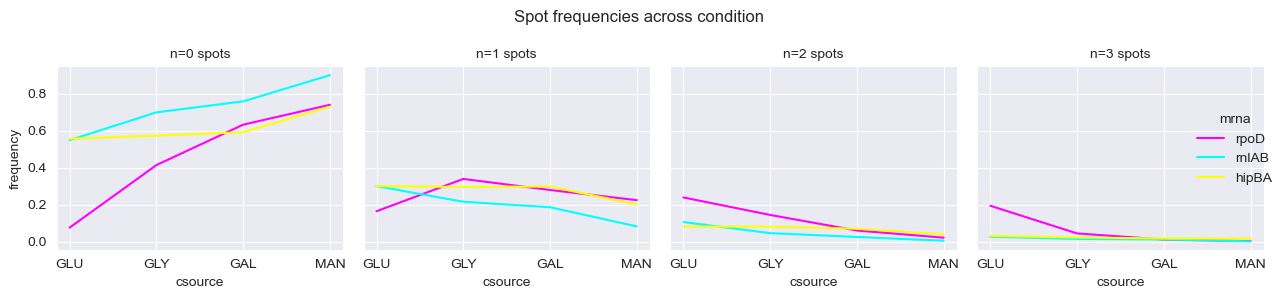

In [1583]:
g = sns.relplot(data=histograms.query('rank < 4').query('csource != "LB"'), x='csource', y='frequency',
            col='rank', hue='mrna', palette=palette_mrna, kind='line', height=3)
g.set_titles('n={col_name} spots')
# g.set(yscale="log")
g.fig.suptitle("Spot frequencies across condition")
plt.tight_layout();

### Expression versus cell features

#### Area

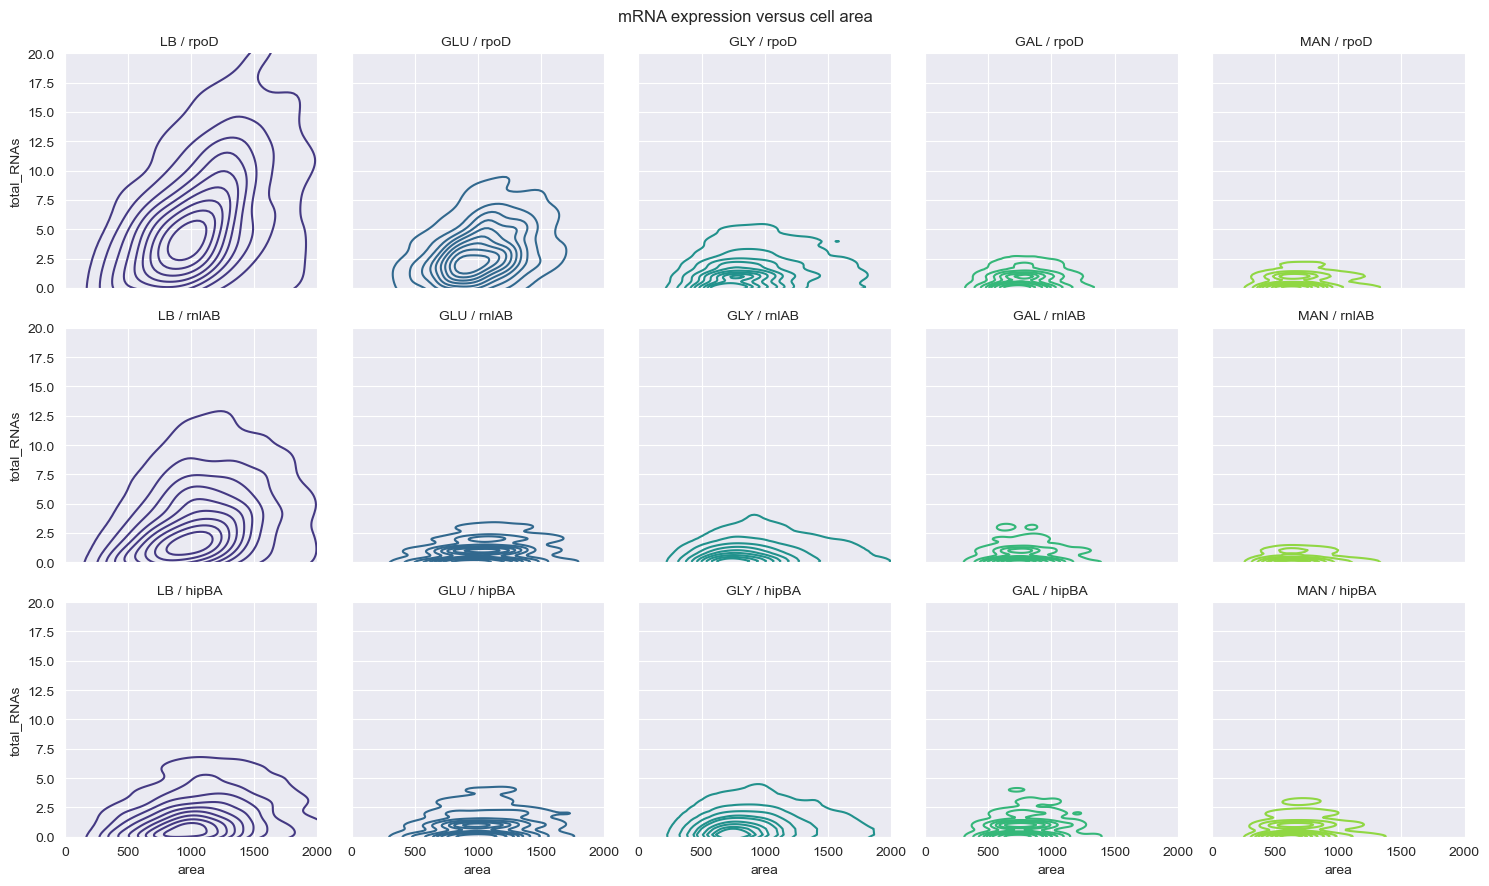

In [1228]:
g = sns.FacetGrid(df_stacked.query('replicate == "exp22"'), 
                  row='mrna', row_order=mrna_ordered, 
                  col='csource', col_order=csources_ordered, 
                  xlim=(0, 2000), ylim=(0, 20),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.kdeplot, y='total_RNAs', x='area', hue='csource', palette=palette_csource)
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression versus cell area')
g.tight_layout();

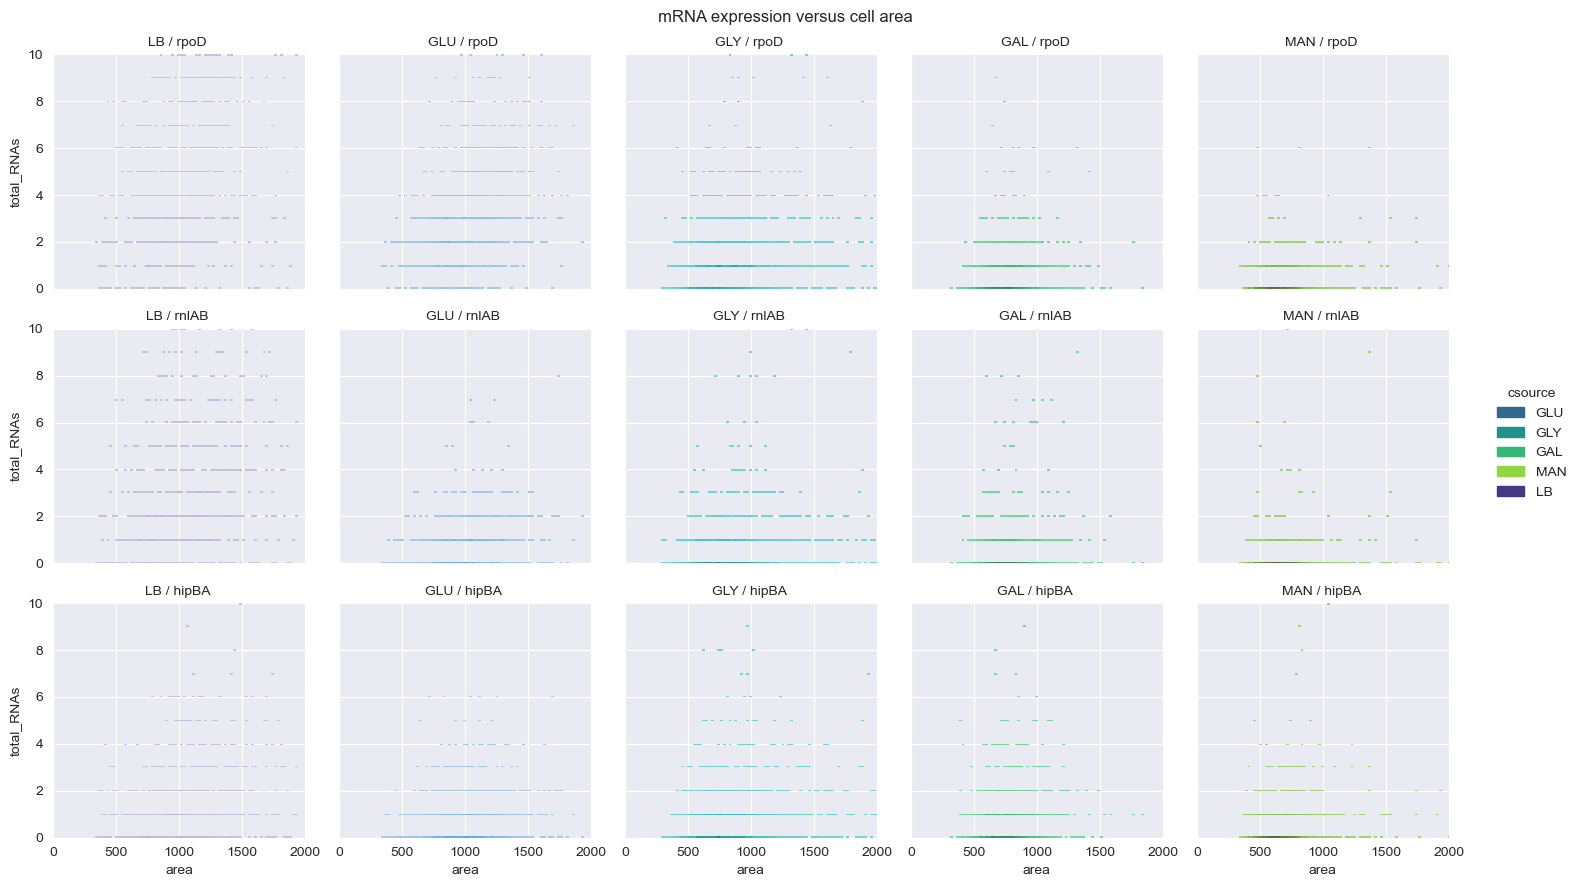

In [1489]:
g = sns.displot(df_stacked.query('replicate == "exp22"'), 
                row='mrna', row_order=mrna_ordered, 
                col='csource', col_order=csources_ordered, 
                x='area', y='total_RNAs', hue='csource', palette=palette_csource,
                height=3)
g.set(xlim=(0, 2000), ylim=(0, 10))
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression versus cell area')
g.tight_layout();

#### Eccentricity

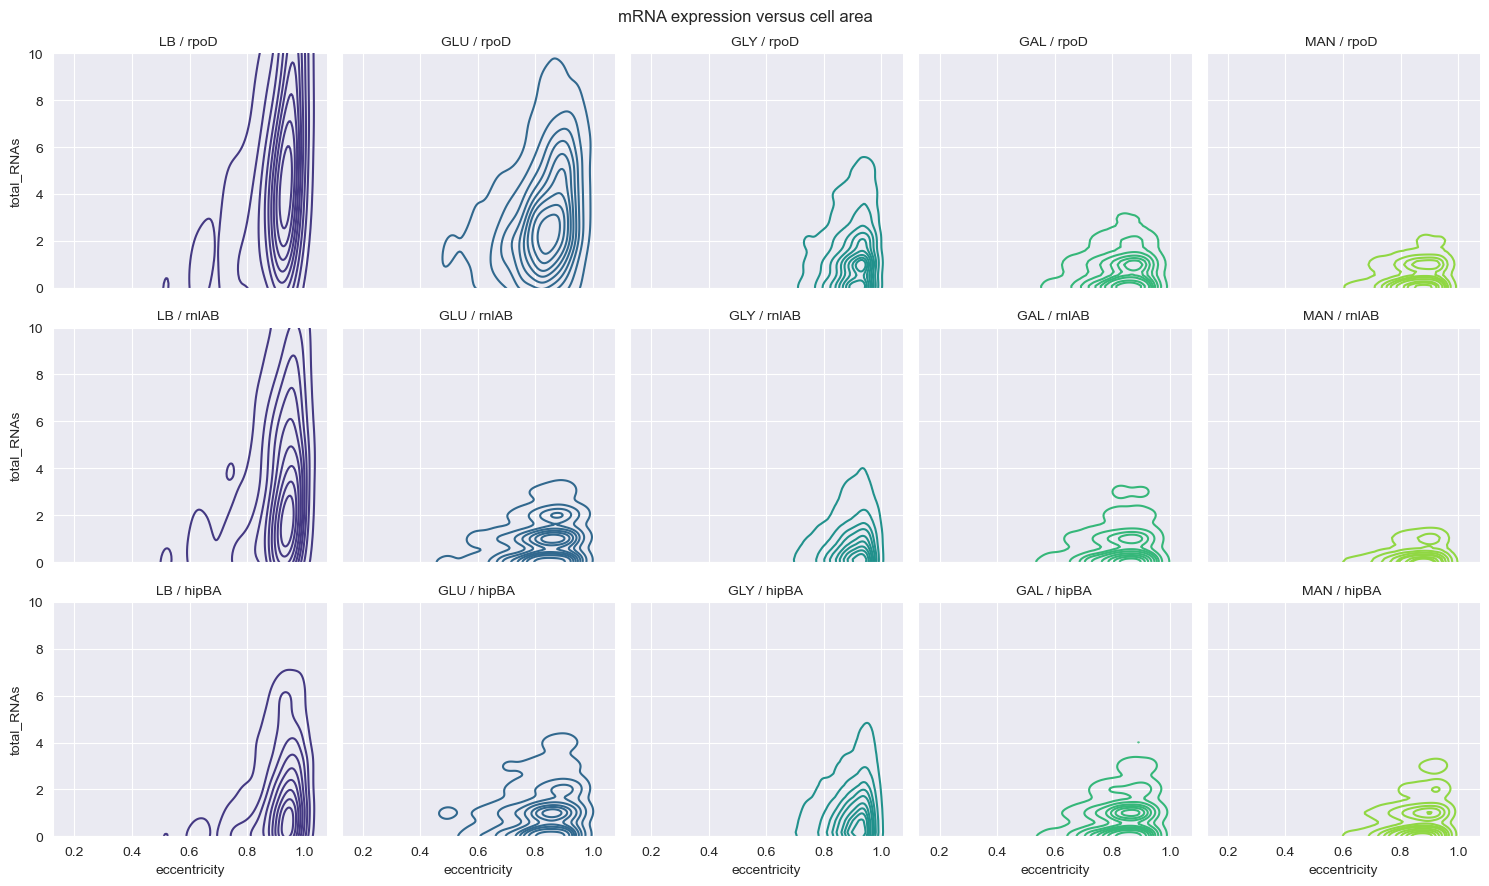

In [1229]:
g = sns.FacetGrid(df_stacked.query('replicate == "exp22"'), 
                  row='mrna', row_order=mrna_ordered, 
                  col='csource', col_order=csources_ordered, 
                  ylim=(0, 10),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.kdeplot, y='total_RNAs', x='eccentricity', hue='csource', palette=palette_csource)
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression versus cell area')
g.tight_layout();

### Co-expression

#### 2D histograms

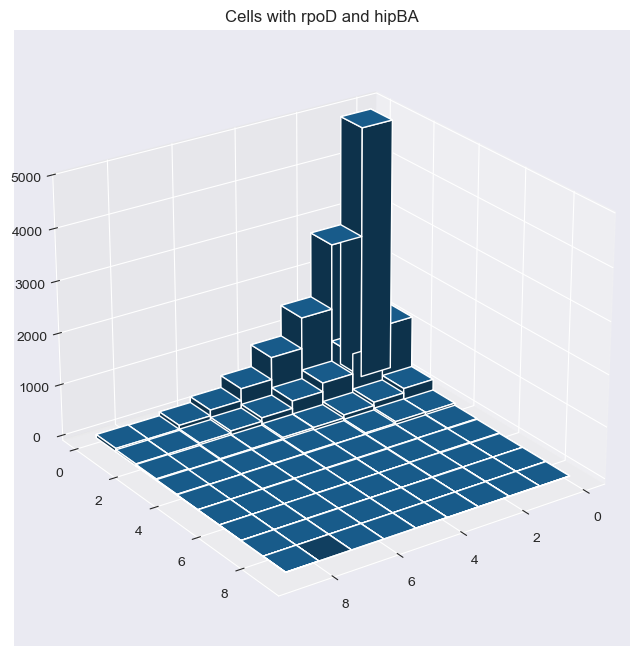

In [1584]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
x, y = df_records_sane['total_RNAs_rpoD'], df_records_sane['total_RNAs_hipBA']
hist, xedges, yedges = np.histogram2d(y, x, bins=9, range=[[0, 9], [0, 9]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="xy")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 1
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.view_init(25, 55)
plt.title("Cells with rpoD and hipBA")
plt.show()

#### Density plots

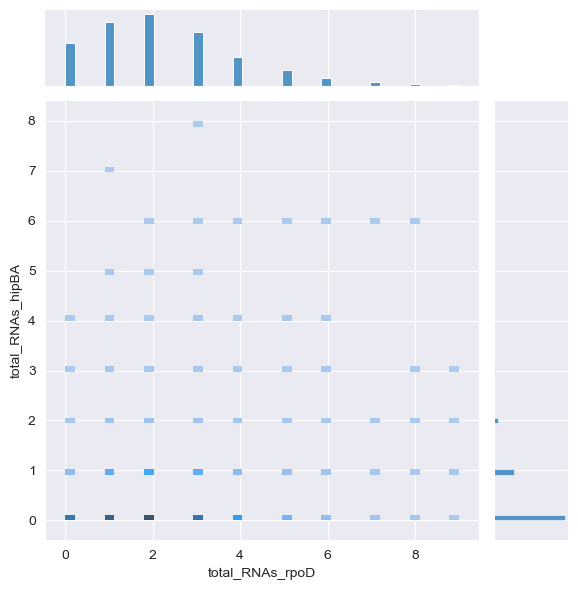

In [1484]:
df_records_sane = df_records.query('total_RNAs_rpoD < 10').query('total_RNAs_rnlAB < 10').query('total_RNAs_hipBA < 10')
sns.jointplot(data=df_records_sane.query('csource == "GLU"'), x='total_RNAs_rpoD', y='total_RNAs_hipBA', kind='hist');

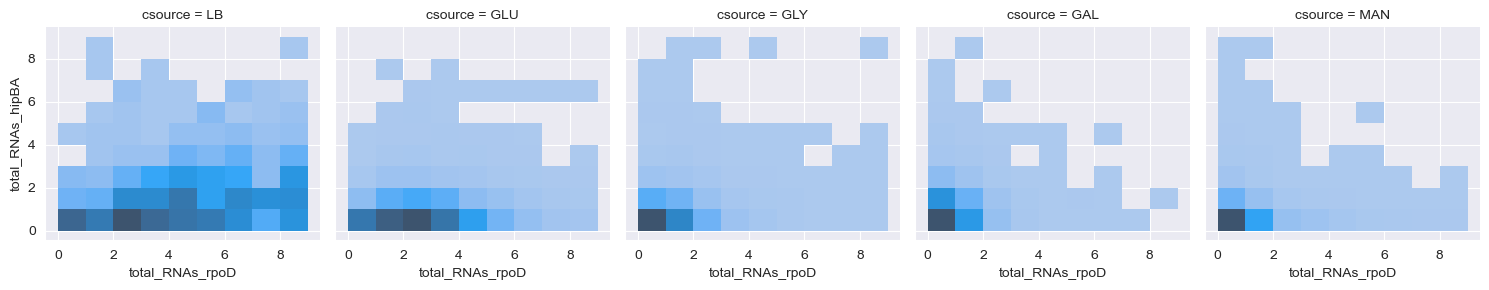

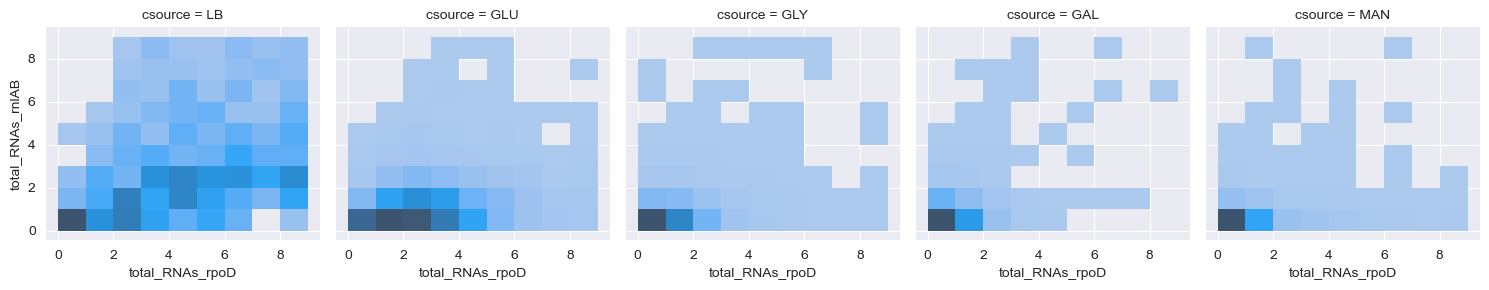

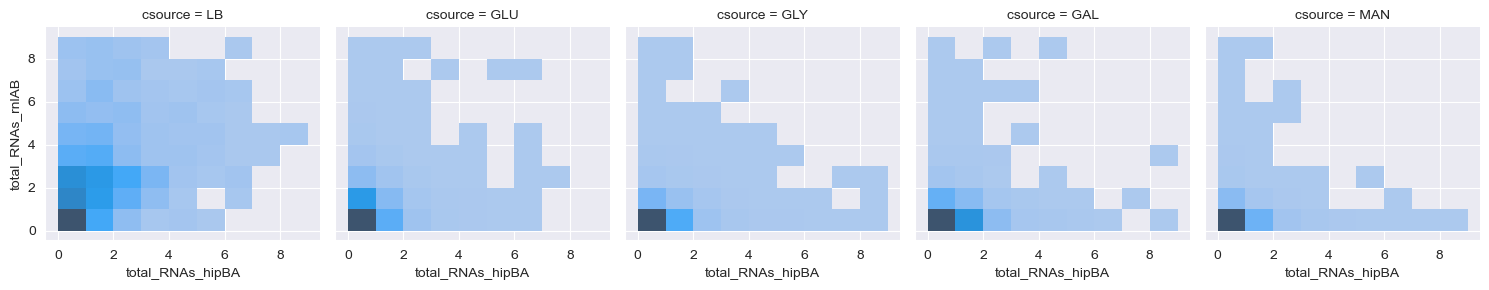

In [1482]:
fill=True
g1 =sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g1.map_dataframe(sns.histplot, x='total_RNAs_rpoD', y='total_RNAs_hipBA', binwidth=1)

g2 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g2.map_dataframe(sns.histplot, x='total_RNAs_rpoD', y='total_RNAs_rnlAB', binwidth=1)

g3 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g3.map_dataframe(sns.histplot, x='total_RNAs_hipBA', y='total_RNAs_rnlAB', binwidth=1);

#### Fraction of cells with two RNAs

In [654]:
#  same content as cell below, just easier to check
df_counts = pd.DataFrame({
    'total': df_records.groupby('csource').size().reindex(csources_ordered),
    'rpoD': df_records.query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB': df_records.query('spots_rnlAB > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA': df_records.query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&hipBA': df_records.query('spots_rnlAB > 0').query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&rpoD': df_records.query('spots_rnlAB > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA&rpoD': df_records.query('spots_hipBA > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
})

df_counts['%rpoD'] = df_counts['rpoD'] / df_counts['total']
df_counts['%rnlAB'] = df_counts['rnlAB'] / df_counts['total']
df_counts['%hipBA'] = df_counts['hipBA'] / df_counts['total']
df_counts['%rnlAB*%hipBA'] = df_counts['%rnlAB'] * df_counts['%hipBA']
df_counts['%rnlAB&hipBA'] = df_counts['rnlAB&hipBA'] / df_counts['total']
df_counts['%rnlAB&rpoD'] = df_counts['rnlAB&rpoD'] / df_counts['total']
df_counts['%hipBA&rpoD'] = df_counts['hipBA&rpoD'] / df_counts['total']
# df_counts = df_counts[['total', 'rpoD', '%rpoD', 'hipBA', '%hipBA', 'rnlAB', '%rnlAB', '%rnlAB*%hipBA', '%rnlAB&hipBA', '%rnlAB&rpoD', '%hipBA&rpoD']]
df_counts

,total,rpoD,rnlAB,hipBA,rnlAB&hipBA,rnlAB&rpoD,hipBA&rpoD,%rpoD,%rnlAB,%hipBA,%rnlAB*%hipBA,%rnlAB&hipBA,%rnlAB&rpoD,%hipBA&rpoD
csource,,,,,,,,,,,,,,
LB,813,758,671,517,470,659,500,0.93,0.83,0.64,0.52,0.58,0.81,0.62
GLU,5284,4503,2111,1477,690,1972,1350,0.85,0.40,0.28,0.11,0.13,0.37,0.26
GLY,5084,2536,1061,1438,421,693,827,0.50,0.21,0.28,0.06,0.08,0.14,0.16
GAL,2348,842,502,864,221,227,334,0.36,0.21,0.37,0.08,0.09,0.10,0.14
MAN,3523,1286,472,774,113,255,296,0.37,0.13,0.22,0.03,0.03,0.07,0.08


In [655]:
all_frequencies = pd.DataFrame()

total_cells = df_records.groupby('csource').size().reindex(csources_ordered)

for mrna in ['rpoD', 'rnlAB', 'hipBA']:
    df_mrna = pd.DataFrame({'counts': df_records.query(f'spots_{mrna} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna
    df_mrna['cardinality'] = 1
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    
    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
for mrna_pair in combinations(['rpoD', 'rnlAB', 'hipBA'], 2):
    df_mrna = pd.DataFrame({'counts': df_records.query(f'spots_{mrna_pair[0]} > 0').query(f'spots_{mrna_pair[1]} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna_pair[0] + '_' + mrna_pair[1]
    df_mrna['cardinality'] = 2
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    df_mrna['expected'] = all_frequencies.query('mrna_set == @mrna_pair[0]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[1]')['fraction']
    
    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
for mrna_pair in combinations(['rpoD', 'rnlAB', 'hipBA'], 3):
    df_mrna = pd.DataFrame({'counts': df_records.query(f'spots_{mrna_pair[0]} > 0').query(f'spots_{mrna_pair[1]} > 0').query(f'spots_{mrna_pair[2]} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna_pair[0] + '_' + mrna_pair[1] + '_' + mrna_pair[2]
    df_mrna['cardinality'] = 3
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    df_mrna['expected'] = all_frequencies.query('mrna_set == @mrna_pair[0]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[1]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[2]')['fraction']

    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
all_frequencies

,counts,mrna_set,cardinality,total,fraction,expected
csource,,,,,,
LB,758,rpoD,1,813,0.93,NaN
GLU,4503,rpoD,1,5284,0.85,NaN
GLY,2536,rpoD,1,5084,0.50,NaN
GAL,842,rpoD,1,2348,0.36,NaN
MAN,1286,rpoD,1,3523,0.37,NaN
LB,671,rnlAB,1,813,0.83,NaN
GLU,2111,rnlAB,1,5284,0.40,NaN
GLY,1061,rnlAB,1,5084,0.21,NaN
GAL,502,rnlAB,1,2348,0.21,NaN


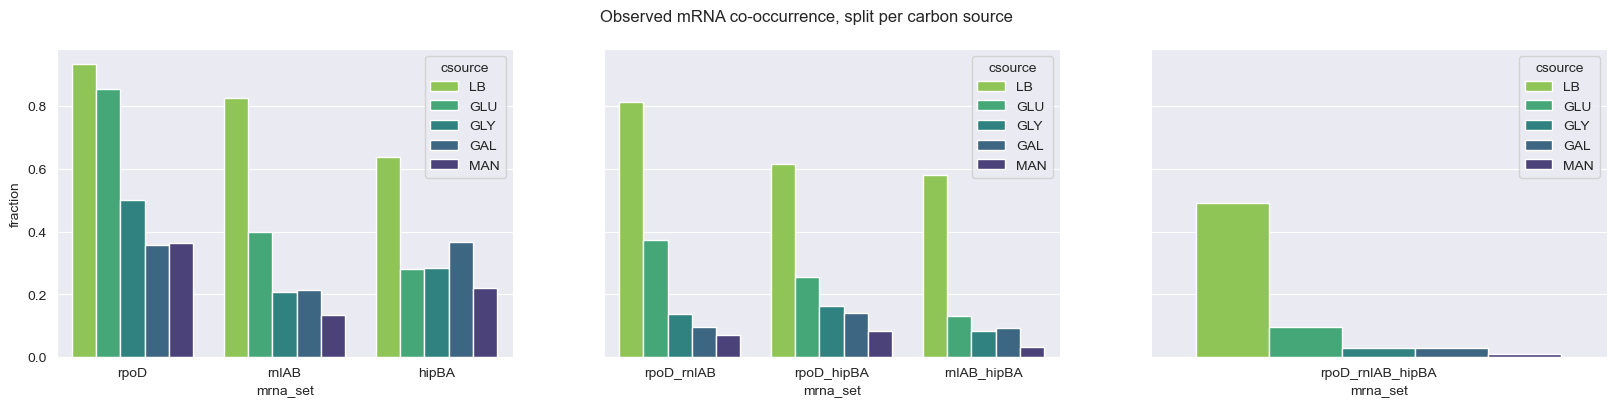

In [656]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence, split per carbon source')

g = sns.barplot(all_frequencies.query('cardinality == 1'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 3'), x='mrna_set', y='expected', hue='csource', palette=palette_csource, ax=ax[2])

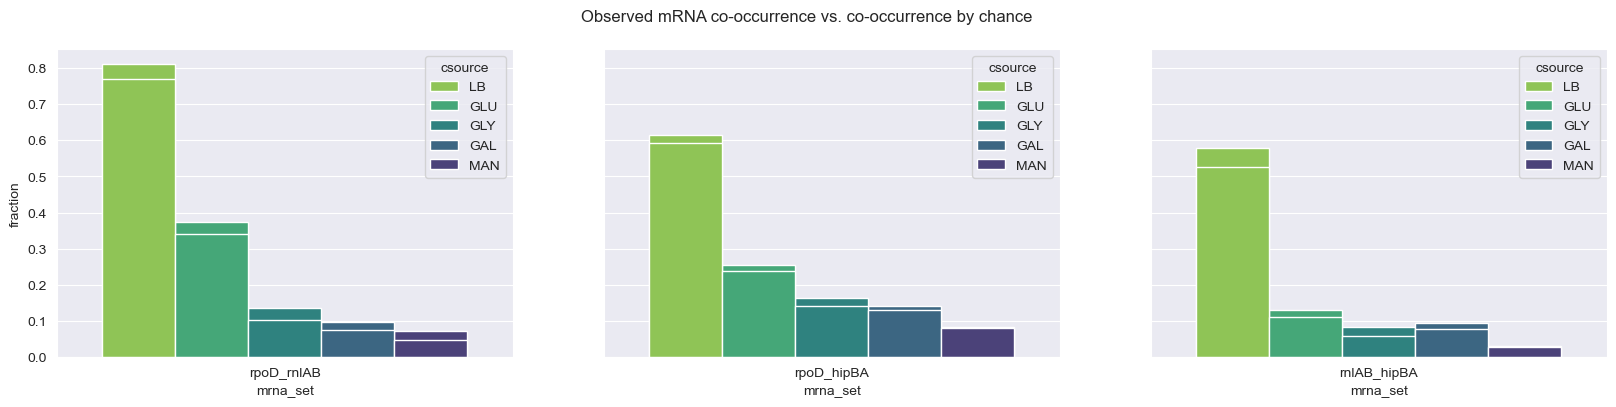

In [657]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[2], legend=False)

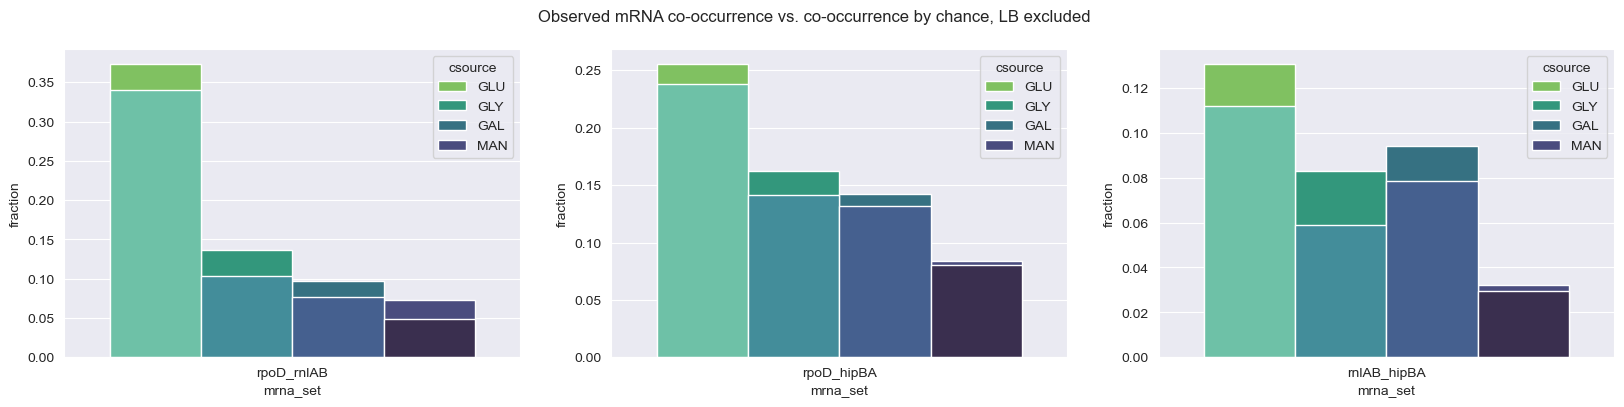

In [658]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=False)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance, LB excluded')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[2], legend=False)

#### Area and eccentricity of cells with both RNAs

### Localisation

#### Distance of spots to cell centroid/closest cell tip
 

#### Distance of spots to cell mask

#### Distance of spots to closest nucleoid tip

#### Distance of spots to nuclei


### Transcription sites

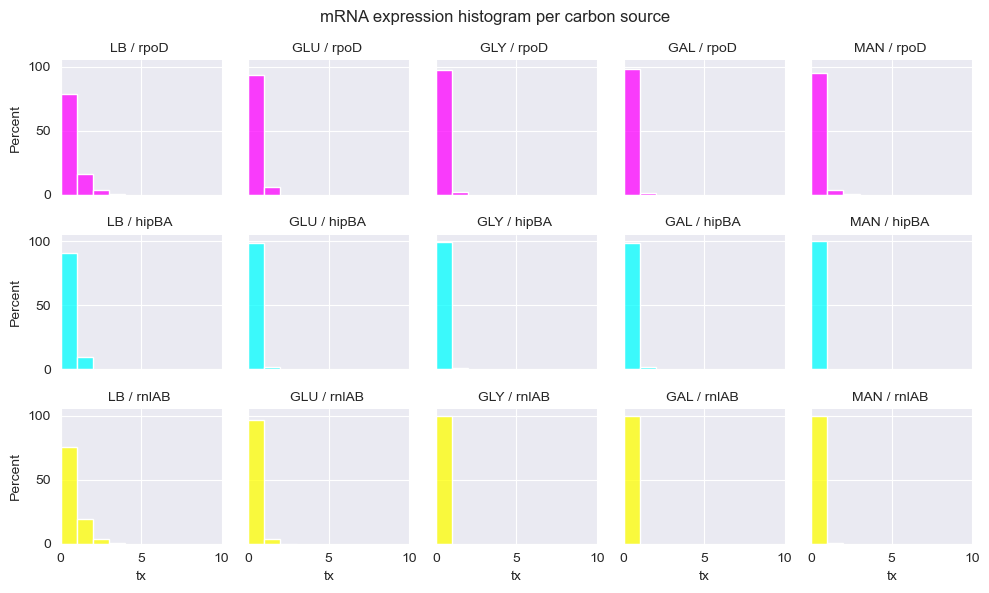

In [671]:
g = sns.FacetGrid(df_stacked, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='tx', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();


## Quality control

### Inspect images individually

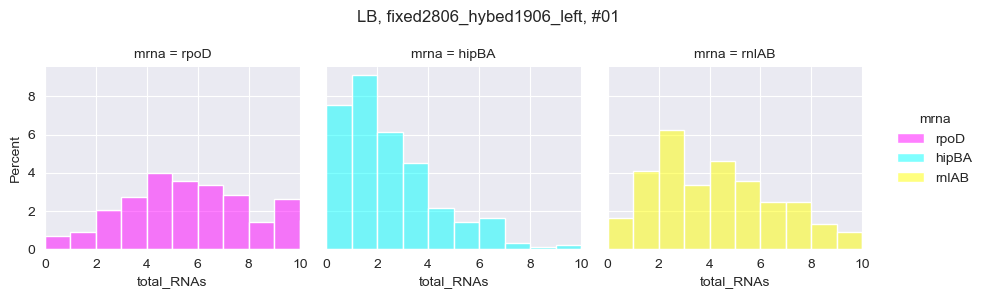

In [672]:
image = 'MG1655_LB_fixed2806_hybed1906_left_01'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

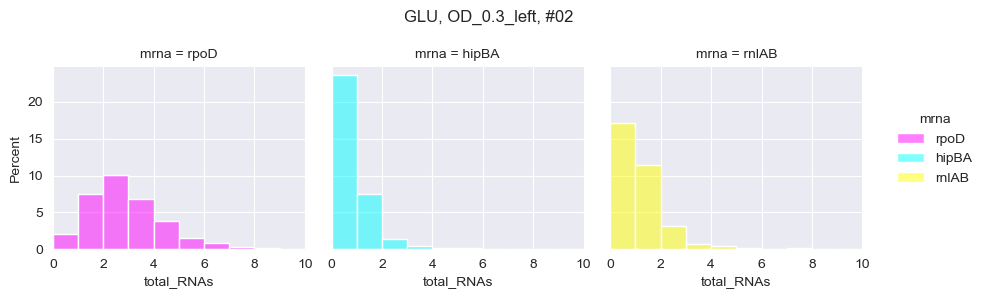

In [673]:
image = 'MG1655_GLU_OD_0.3_left_02'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

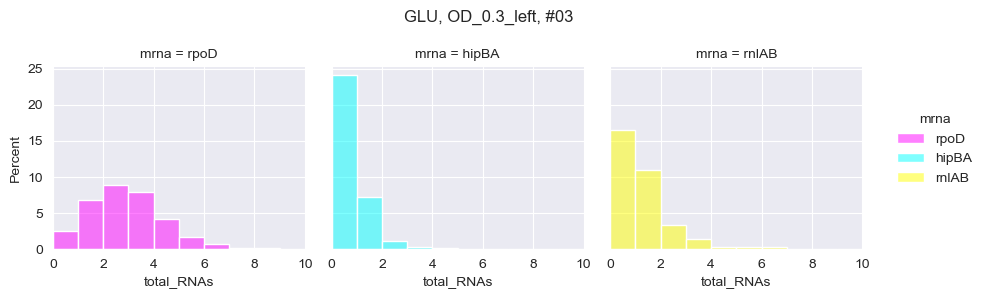

In [674]:
image = 'MG1655_GLU_OD_0.3_left_03'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

### Spot intensity histograms
Spots in cells versus spots outside cells

See `intensities.ipynb` notebook.